In [ ]:
!unzip tomato.zip -d small_dataset
!pip install shap

In [ ]:
!pip install opencv-python

### 13-5 番茄葉

1.匯入套件

# os 資料夾操作
cv2 影像操作 (pip install opencv-python)
numpy 矩陣運算套件
matplotlib 繪圖工具
seaborn 繪圖工具 (資料視覺化: pip install Seaborn)
sklearn 資料處理與機器學習套件
keras 深度學習套件

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2. 資料觀察

不健康的葉子

In [ ]:
para = cv2.imread('./small_dataset/unhealthy/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG')
para = cv2.cvtColor(para, cv2.COLOR_BGR2RGB)
plt.imshow(para)
print("圖片大小與長寬與顏色為:"+str(para.shape))

健康的葉子

圖片大小與長寬與顏色為:(256, 256, 3)


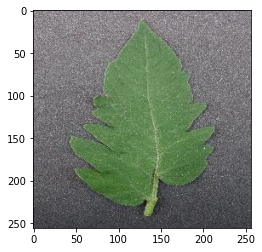

In [4]:
un = cv2.imread('./small_dataset/healthy/000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG')
un = cv2.cvtColor(un, cv2.COLOR_BGR2RGB)
plt.imshow(un)
print("圖片大小與長寬與顏色為:"+str(un.shape))

3.資料前處理

將資料按照以下步驟 整理成 data 與 label 的形式 , 才能符合CNN模型input的需求

創建data 與 label 的 空list

迴圈讀取健康葉子與不健康葉子的圖像,並在迴圈內執行以下前處理

2-1. 圖片大小整合(resize)

2-2. 圖片加入至data

2-3. 自定義label (0or1) 後加入至label

將data 與 label 從list轉為np.array 型態 才可輸入至CNN模型

將label 進行 one hot encoding

將data / 255 , 因為data內包含所有圖片,而圖片像素內的值為0~255

為使CNN訓練收斂較好 , 除以255 (MinMaxScaler) *會有幫助*

In [5]:
data = [] # 1 step
label = []
for i in os.listdir("./small_dataset/healthy/"): # 2 step
    img = cv2.imread('./small_dataset/healthy/'+i)
    img = cv2.resize(img,(50,50),interpolation=cv2.INTER_CUBIC) # 2-1
    data.append(img) # 2-2
    label.append(0) # 2-3
for i in os.listdir("./small_dataset/unhealthy/"):
    img = cv2.imread('./small_dataset/unhealthy/'+i)
    img = cv2.resize(img,(50,50),interpolation=cv2.INTER_CUBIC) # 2-1
    data.append(img) # 2-2
    label.append(1) # 2-3

data = np.array(data) # 3
label = np.array(label) #3

label_one_hot = to_categorical(label) # 4

data_norm = data / 255 #5

上方製作的資料由於是順序讀取資料夾內容,需要經過洗牌(shuffle)才能放入模型進行訓練

否則在前半段模型只會看到健康的葉子,後半段只看到不健康的葉子,對模型收斂會影響很大

而sklearn 中 train_test_split 同時能夠完成(訓練與測試集切分)與(shuffle)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data_norm, label_one_hot, test_size=0.33, random_state=42)

In [7]:
X_train.shape

(294, 50, 50, 3)

In [8]:
Y_train.shape

(294, 2)

4. 模型架設
使用順序型的model 架設簡易的CNN模型

image.png

步驟 :

1. 建立捲積(Conv)層與池化(Pooling)層

2. 建立攤平(flatten)層

3. 建立隱藏層(hidden layer)

4. 建立輸出層(output layer)
詳細可參考此網站

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization

model = Sequential()
# Create CN layer 1  
model.add(Conv2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(50,50,3),
                 activation='relu'))
# Create Max-Pool 1  
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization())

# Create CN layer 2  
model.add(Conv2D(filters=36,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

# Create Max-Pool 2  
model.add(MaxPooling2D(pool_size=(2,2)))

# Add Dropout layer  
model.add(Dropout(0.25))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

In [12]:
model.add(Dense(2, activation='softmax'))

In [13]:
model.summary()  
print("") 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 36)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 36)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)             

In [14]:
# 定義訓練方式  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
  
# 開始訓練  
train_history = model.fit(x=X_train, y=Y_train, validation_split=0.2,epochs=30,batch_size=4,verbose=2)


Train on 235 samples, validate on 59 samples
Epoch 1/30
 - 1s - loss: 0.7543 - accuracy: 0.8170 - val_loss: 0.7960 - val_accuracy: 0.4576
Epoch 2/30
 - 1s - loss: 0.1176 - accuracy: 0.9447 - val_loss: 0.4706 - val_accuracy: 0.8644
Epoch 3/30
 - 1s - loss: 0.1047 - accuracy: 0.9574 - val_loss: 0.3079 - val_accuracy: 0.8814
Epoch 4/30
 - 1s - loss: 0.1118 - accuracy: 0.9617 - val_loss: 0.1356 - val_accuracy: 0.9831
Epoch 5/30
 - 1s - loss: 0.0292 - accuracy: 0.9872 - val_loss: 0.0568 - val_accuracy: 1.0000
Epoch 6/30
 - 1s - loss: 0.0348 - accuracy: 0.9872 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 7/30
 - 1s - loss: 0.0113 - accuracy: 0.9957 - val_loss: 0.1960 - val_accuracy: 0.8814
Epoch 8/30
 - 1s - loss: 0.0446 - accuracy: 0.9830 - val_loss: 0.1073 - val_accuracy: 0.9492
Epoch 9/30
 - 1s - loss: 0.0368 - accuracy: 0.9872 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 10/30
 - 1s - loss: 0.0848 - accuracy: 0.9787 - val_loss: 1.0862 - val_accuracy: 0.7797
Epoch 11/30
 - 1s - los

5. 模型預測與評估
5-1 使用matplotlib 繪製訓練曲線圖
左邊為loss曲線 , 右邊為acc曲線

In [15]:
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

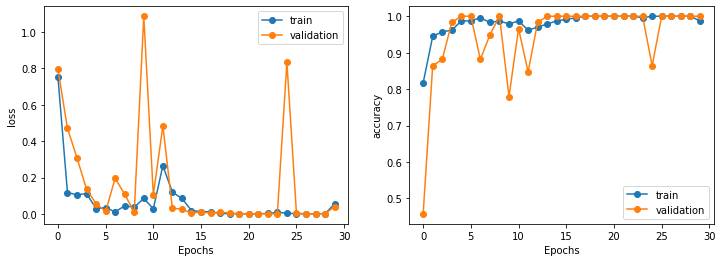

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(train_history, 'loss','val_loss')
plt.subplot(1,2,2)
plot_train_history(train_history, 'accuracy','val_accuracy')

5-2 使用混淆矩陣與模型評估報告觀察模型效能

In [17]:
Y_test = np.argmax(Y_test,axis=1)
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred,axis=1)

              precision    recall  f1-score   support

     Healthy       1.00      0.96      0.98        80
   UnHealthy       0.96      1.00      0.98        66

    accuracy                           0.98       146
   macro avg       0.98      0.98      0.98       146
weighted avg       0.98      0.98      0.98       146



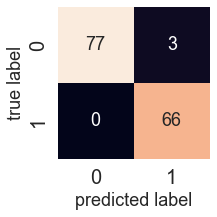

In [18]:
mat = confusion_matrix(Y_test,Y_pred)
sns.set(font_scale=1.5)
plt.subplot(1,2,1)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel('true label')
plt.xlabel('predicted label');

target_names = ["Healthy", "UnHealthy"]
print(classification_report(Y_test, Y_pred, target_names=target_names))